Author: Mikita Sazanovich

Mountain Car domain: <https://gym.openai.com/envs/MountainCar-v0>

In [2]:
class State:
    def __init__(self, position_tile, velocity_tile):
        self.position_tile = position_tile
        self.velocity_tile = velocity_tile

    def __eq__(self, other):
        if isinstance(other, State):
            return (self.position_tile == other.position_tile and
                    self.velocity_tile == other.velocity_tile)
        else:
            return False

    def __hash__(self):
        return hash((self.position_tile, self.velocity_tile))

In [3]:
import numpy as np

ACTIONS_COUNT = 3
eps_greedy = 0


def find_best_action_quality(Q, state):
    best_action, best_q = None, None
    for action in range(ACTIONS_COUNT):
        cur_q = Q[(state, action)]
        if best_q is None or best_q < cur_q:
            best_action, best_q = action, cur_q
    return best_action, best_q


def choose_eps_greedy_action(Q, state):
    best_action, best_q = find_best_action_quality(Q, state)
    best_count = 0
    for action in range(ACTIONS_COUNT):
        if Q[(state, action)] == best_q:
            best_count += 1
    p = []
    for action in range(ACTIONS_COUNT):
        prob = eps_greedy / ACTIONS_COUNT
        if Q[(state, action)] == best_q:
            prob += (1 - eps_greedy) / best_count
        p.append(prob)
    return np.random.choice(ACTIONS_COUNT, 1, p=p)[0]


def map_observation_to_state(observation, position_grid, velocity_grid):
    return State(int(round(observation[0] / position_grid)),
                 int(round(observation[1] / velocity_grid)))

In [9]:
import gym
from collections import defaultdict

training_episodes = 5000
timesteps_limit = 200  # limit from OpenAI gym

gamma = 0.9


def evaluate_parameters(alpha, position_grid, velocity_grid):
    env = gym.make('MountainCar-v0')
    env.seed(0)
    np.random.seed(0)
    cumulative_completion = []
    completed = 0
    Q = defaultdict(lambda: 0.0)
    for episode in range(training_episodes):
        observation = env.reset()
        state = map_observation_to_state(
            observation, position_grid, velocity_grid)
        action = choose_eps_greedy_action(Q, state)
        for timestep in range(timesteps_limit):
            observation, reward, done, info = env.step(action)
            to_state = map_observation_to_state(
                observation, position_grid, velocity_grid)
            next_action = choose_eps_greedy_action(Q, to_state)
            Q[(state, action)] += alpha * (reward +
                                           gamma * Q[(to_state, next_action)] -
                                           Q[(state, action)])
            action, state = next_action, to_state
            if done:
                if timestep != timesteps_limit - 1:
                    completed += 1
                cumulative_completion.append(completed)
                break
    env.close()
    return cumulative_completion

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline


def evaluate_and_plot_parameters(alpha, position_grid, velocity_grid, color):
    cumulative_completion = evaluate_parameters(alpha, position_grid, velocity_grid)
    title = f'alpha={alpha} pos_grid={position_grid} vel_grid={velocity_grid}'
    print(f'Evaluated {title}')
    line, = plt.plot(
        np.arange(1, training_episodes + 1),
        cumulative_completion,
        c=next(color),
        label=title)
    return line

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Evaluated alpha=0.5 pos_grid=0.1 vel_grid=0.01
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Evaluated alpha=0.5 pos_grid=0.05 vel_grid=0.01
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Evaluated alpha=0.5 pos_grid=0.01 vel_grid=0.01
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Evaluated alpha=0.25 pos_grid=0.1 vel_grid=0.01
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Evaluated alpha=0.25 pos_grid=0.05 vel_grid=0.01


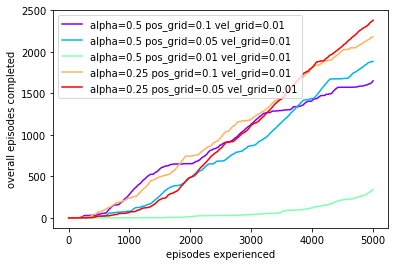

In [17]:
from matplotlib.pyplot import cm


color = iter(cm.rainbow(np.linspace(0, 1, 5)))
handles = []

alpha, position_grid, velocity_grid = 0.5, 0.1, 0.01
handles.append(evaluate_and_plot_parameters(
    alpha, position_grid, velocity_grid, color
))

alpha, position_grid, velocity_grid = 0.5, 0.05, 0.01
handles.append(evaluate_and_plot_parameters(
    alpha, position_grid, velocity_grid, color
))

alpha, position_grid, velocity_grid = 0.5, 0.01, 0.01
handles.append(evaluate_and_plot_parameters(
    alpha, position_grid, velocity_grid, color
))

alpha, position_grid, velocity_grid = 0.25, 0.1, 0.01
handles.append(evaluate_and_plot_parameters(
    alpha, position_grid, velocity_grid, color
))

alpha, position_grid, velocity_grid = 0.25, 0.05, 0.01
handles.append(evaluate_and_plot_parameters(
    alpha, position_grid, velocity_grid, color
))

plt.xlabel('episodes experienced')
plt.ylabel('overall episodes completed')
plt.legend(handles=handles)

As we can see the parameters that lead to the best results in the long run are: steady learning rate -- alpha=0.25, pos_grid=0.05, vel_grid=0.01. Actually, it completes almost every game (linear growth) starting from 2000-th iteration. 

The cool part, of course, being that the agent learned how to complete the task without us giving any knowledge to it (however, you can argue that giving reward in such a way IS providing the knowledge). Impressive!

But probably, it is just much more fun when we are able to visually observe the [agent's performance](https://www.youtube.com/watch?v=7sgilwJ9Fig). :)